# FeelNet

## Preprocesado

In [ ]:
import nltk
import string
!pip install emoji
import emoji
import math
import re
import os
import collections
import matplotlib.pyplot as plt

nltk.download('stopwords')
# nltk.download('punkt')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
# from nltk.stem import WordNetLemmatizer
# from spellchecker import SpellChecker

import pandas as pd
import kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 7.3 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Carga de datos y pequeño análisis

In [ ]:
dataset = pd.read_csv('raw_dataset.csv')
dataset.head()

,text,labels
0,My favourite food is anything I didn't have to...,4
1,"Now if he does off himself, everyone will thin...",4
2,WHY THE FUCK IS BAYLESS ISOING,0
3,To make her feel threatened,2
4,Dirty Southern Wankers,0


Traducción etiqueta - sentmiento:
- 0: anger
- 1: disgust
- 2: fear
- 3: joy
- 4: neutral
- 5: sadness
- 6: surprise

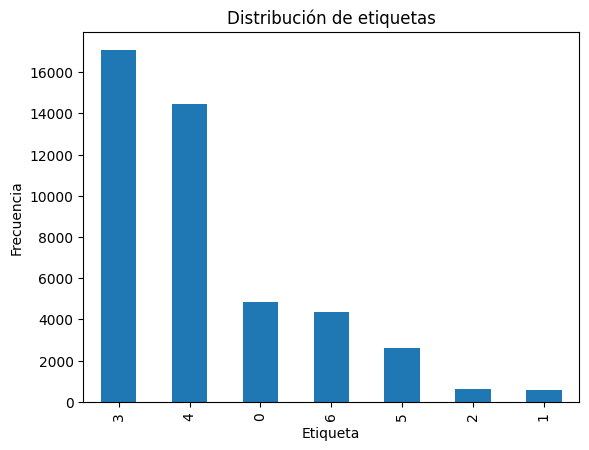

In [ ]:
# dataset.columns
distribution = dataset['labels'].value_counts()
distribution.plot(kind='bar')
plt.title('Distribución de etiquetas')
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.show()

Valores nulos

In [ ]:
has_null = dataset.isna().any().any()
print(f"Dataset has null value: {has_null}")

Dataset has null value: False


###Tratamiento de cosas

In [ ]:
# Comprobamos si hay saltos de líneas
has_newlines = dataset.map(lambda x: '\n' in str(x)).any().any()

print(f"Does the DataFrame contain newlines? {has_newlines}")

data_string = '\n'.join(dataset['text'])

Does the DataFrame contain newlines? False


In [ ]:
# Set to lowercase and erase punctuation symbols
#translate_table = dict((ord(char), ' ') for char in string.punctuation)
#lower_text = data_string.lower().translate(translate_table)

lower_text = data_string.lower()

# Regular expression to match punctuation
# Matches all punctuation except colons followed by 1–2 non-whitespace characters
pattern = rf"[:;][^\s]{{1,2}}|[{re.escape(string.punctuation)}]"

# Replace matches with a space, keeping valid emoji-like patterns
lower_text = re.sub(pattern, lambda m: f"<{m.group()}>" if re.fullmatch(r"[:;][^\s]{1,2}", m.group()) else " ", lower_text)

print(lower_text[0:500])

my favourite food is anything i didn t have to cook myself 
now if he does off himself  everyone will think hes having a laugh screwing with people instead of actually dead
why the fuck is bayless isoing
to make her feel threatened
dirty southern wankers
omg peyton isn t good enough to help us in the playoffs  dumbass broncos fans circa december 2015 
yes i heard abt the f bombs  that has to be why  thanks for your reply<:)> until then hubby and i will anxiously wait 😝
we need more boards and to


In [ ]:
# EMOJIS
lower_text = emoji.demojize(lower_text)

In [ ]:
# Volver a lista de tweets
tweets_tratados = lower_text.splitlines()

In [ ]:
# Remove stop words & stemming
stemmer = PorterStemmer()
stemmed_tweets = [[stemmer.stem(w) for w in text.split()] for text in tweets_tratados]

# lemmatizer = WordNetLemmatizer()
# unique_tokens = set([lemmatizer.lemmatize(t) for t in unique_tokens])

stop_words =  stopwords.words('english')

In [ ]:
stemmed_tweets[982]

['by',
 'rant',
 'aimlessli',
 'on',
 'the',
 'internet',
 'about',
 'it',
 'obvious',
 '<;)>']

In [ ]:
processed_text = [[t for t in text if t not in stop_words] for text in stemmed_tweets]
proccessed_text = '\n'.join([' '.join(tweet) for tweet in stemmed_tweets])
print(proccessed_text[:200])

my favourit food is anyth i didn t have to cook myself
now if he doe off himself everyon will think he have a laugh screw with peopl instead of actual dead
whi the fuck is bayless iso
to make her feel


In [ ]:
## Special tokens
# end_tokens = re.sub(r'\b(\w*((\d+[a-z]+)|([a-z]+\d+))\w*)\b', lambda x: f' <ALPHANUM> ', clean_tokens)
proccessed_text = re.sub(r'\b\w*?(\d+)\w*?\b', lambda x: f' <NUMBER{len(x.group(1))}> ', proccessed_text)

# the same letter 3 consecutively times
proccessed_text = re.sub(r'\b\w*([a-z])\1\1\w*\b', ' <TRASH> ', proccessed_text)

# # HTML
# end_tokens = re.sub(r'html', ' <HTMLA> ', end_tokens)

# EMOJI
proccessed_text = re.sub(r'\b:(.*?):\b', lambda x: f' <{x.group(1)}> ', proccessed_text)

# NO VOWEL: tv, dvd, ...
#proccessed_text = re.sub(r'\b[^\sAEIOUYaeyiou]+[^\sAEIOUYaeyiou]+\b', ' <NOVOW> ', proccessed_text)

# # speller
# print("Speller")fda
# spell = SpellChecker()

# sorted_result = sorted(set(spell.correction(token) for token in end_tokens.split(" ")))

# Limpiamos 2 o mas espacios consecutivos por uno solo
proccessed_text = re.sub(r' +', ' ', proccessed_text)
new_text = proccessed_text.splitlines()

# limpiamos espacios intermedios y por la izquierda

new_text = [text.strip() for text in new_text]

dataset['text'] = new_text

# Eliminamos valores vacíos
dataset = dataset.replace("", pd.NA)  # pd.NA es un equivalente moderno a NaN
dataset = dataset.dropna()

dataset.to_csv('out.csv', index=False)